In [1]:
import numpy as np
from scipy.io import wavfile
import scipy.stats as stats
from python_speech_features import sigproc
import matplotlib.pyplot as plt
import pickle
import pylab
from scipy.signal import butter, sosfilt, sosfreqz
import features

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [3]:
def graph_spectrogram(wav_file):
    frame_rate, sound_info  = wavfile.read(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')

In [2]:
collected_files = pickle.load(open("collected_enrollment_data.f","rb"))
collected_test_files = pickle.load(open("test_phrases.f","rb"))

In [6]:
def zeroCross(signal,samplerate,winlen= 0.025,startframes = 10, dev = 3,endframes =10, plot_noise=False):
    
    preemph=0.97
    winlen=0.01
    winfunc=np.hamming
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate,  winlen*samplerate)
    numOfFrames,sizeOfFrame = frames.shape
    
    ZCR=np.zeros(numOfFrames)
   
    for i in range(numOfFrames):
        f = frames[i,:]
        f2 = np.zeros(sizeOfFrame)
        f2[1:]= f[: -1]
        ZCR[i] = 1/(2*len(f))*sum(abs(np.sign(f)-np.sign(f2)))
#     ZCR = (ZCR/max(ZCR))[:-1]
    
    first_samples = np.concatenate((ZCR[:startframes], ZCR[:-endframes]), axis=None)
    mean = np.mean(first_samples)
    std = np.std(first_samples)
    indexes = np.array([]) #frames to keep

    temp = []
    for i in range(len(ZCR)):
        d = (abs(ZCR[i]- mean))/std
#         print(d)
        if(d>dev): 
            if(len(indexes) == 0):
                indexes = [i]
            else:
                indexes= np.append(indexes,i)
        temp.append(d)
    plt.plot(temp)
    plt.axhline(y=dev, color='r', linestyle='-')
    plt.show()
#     print(indexes)
    cleaned_signal= sigproc.deframesig(frames[indexes[0]:indexes[-1]],0,winlen*samplerate,  winlen*samplerate)
    return cleaned_signal

In [7]:
def STE_v2(audio_signal,samplerate,winlen= 0.025,startframes = 10, endframes =10, dev = 3,single_phrase=False, mutliple_phrases = False,plot_energy=False):
    
    winlen=0.025
    FFT = 512
    winfunc=np.hamming
    framelen = winlen*samplerate
    preemph=0.97
    
    frames = sigproc.framesig(audio_signal, framelen, framelen, winfunc)
    numOfFrames,sizeOfFrame = frames.shape
    
    powerspec = sigproc.logpowspec(frames,FFT)
    energy = np.sum(powerspec,1)
    energy=medfilt(energy,11)
    
    first_samples = np.concatenate((energy[:startframes], energy[-endframes:]), axis=None)
    mean = np.mean(first_samples)
    std = np.std(first_samples)
    indexes = np.array([])
    
    plt.plot(energy)
    plt.title('Power Spectrum of frames')
    plt.xlabel('Frame')
    plt.ylabel('Power spectrum')
    plt.show()

    temp = []
    for i in range(len(energy)):
        d = (abs(energy[i]- mean))/std
        if(d>dev): 
            if(len(indexes) == 0):
                indexes = [i]
            else:
                indexes= np.append(indexes,i)
        temp.append(d)
        
    plt.plot(temp)
    plt.title('Standard score of ste with')
    plt.xlabel('Frame')
    plt.ylabel('score value')
    plt.axhline(y=dev, color='r', linestyle='-')
    plt.show()
        
    if(single_phrase):

        start = int((indexes[0])*framelen)
        stop = int((indexes[-2])*framelen)
        print(indexes[-1])
        cleaned_signal = audio_signal[start:stop]
#         cleaned_signal= sigproc.deframesig(frames[indexes],stop-start,framelen, framelen,winfunc)
    elif(mutliple_phrases):
        cleaned_signal= sigproc.deframesig(frames[indexes[2:]],0,framelen, framelen,winfunc)
    else:
        raise ValueError("Type of phrase not set")
    
    return cleaned_signal

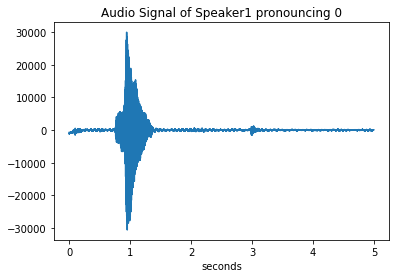

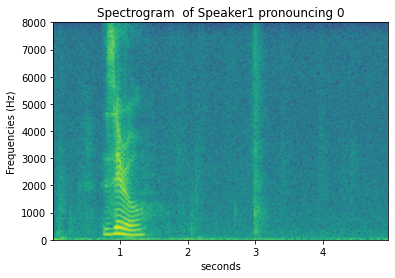

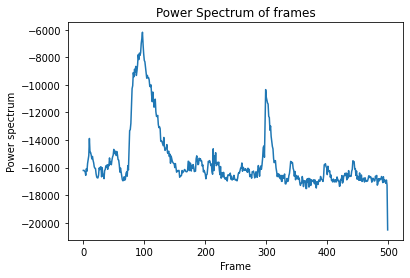

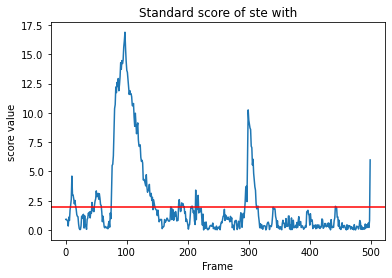

499


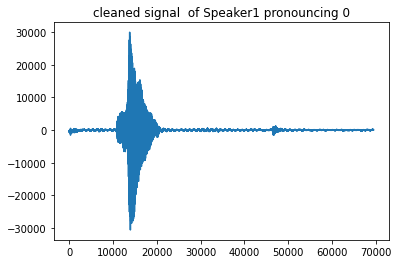

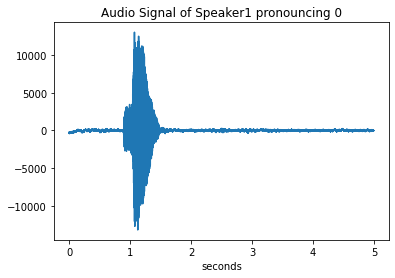

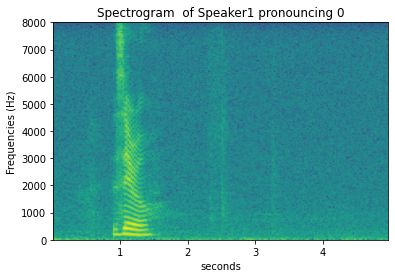

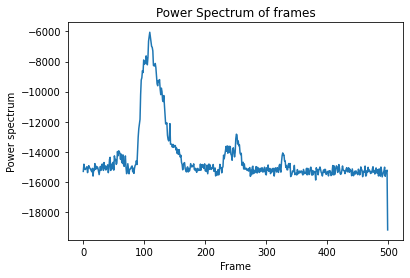

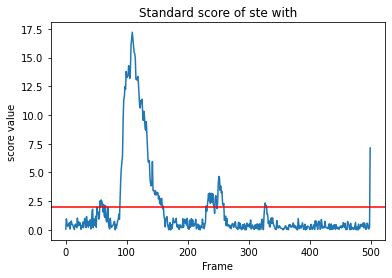

499


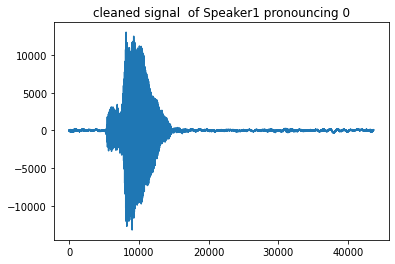

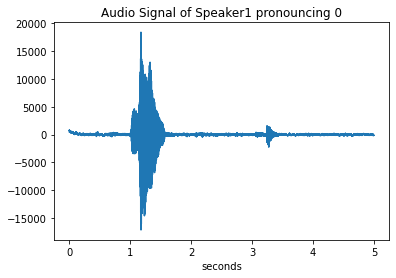

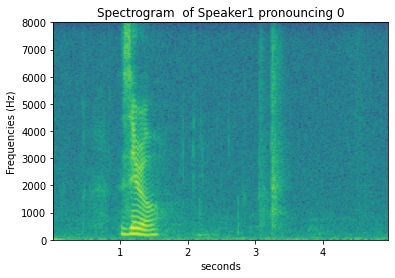

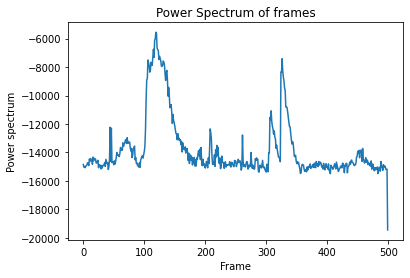

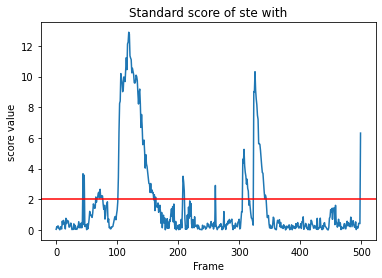

499


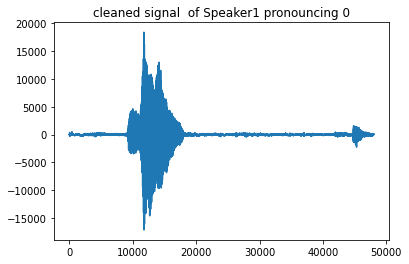

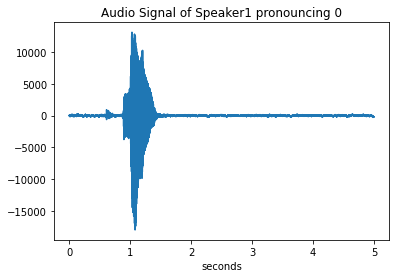

KeyboardInterrupt: 

In [12]:
for s in collected_files:
    length = len(collected_files[s]) #number of digits(words)

    for d in range(length):
        
        utterances = len(collected_files[s][d])
        
        for i in range(utterances):
            sampling_rate, audio_signal = wavfile.read(collected_files[s][d][i])
            filename = collected_files[s][d][i]
            t= np.arange(0,len(audio_signal)/sampling_rate,1/sampling_rate)
            plt.plot(t,audio_signal)
            plt.xlabel("seconds")
            plt.title("Audio Signal of {} pronouncing {}".format(s,d))
            plt.show()
            plt.specgram(audio_signal, NFFT=512, Fs=sampling_rate)
            plt.title("Spectrogram  of {} pronouncing {}".format(s,d))
            plt.xlabel('seconds')
            plt.ylabel('Frequencies (Hz)')
            plt.show()
            cleansig = STE_v2(audio_signal, sampling_rate, startframes=10, endframes=50, dev=2, single_phrase=True, mutliple_phrases=False)
            plt.title("cleaned signal  of {} pronouncing {}".format(s,d))
            plt.plot(cleansig)
            plt.show()

In [ ]:
sampling_rate, audio_signal = wavfile.read('../data\\Speaker1\\digits\\0_Speaker1_1.wav')

t= np.arange(0,len(audio_signal)/sampling_rate,1/sampling_rate)
plt.plot(audio_signal)
plt.xlabel("seconds")
plt.title("Audio Signal of Speaker 9 pronouncing zero (0)")
plt.show()
plt.savefig('Single_digit_audioFile.png')
plt.specgram(audio_signal, NFFT=512, Fs=sampling_rate)
plt.title('Spectrogram')
plt.xlabel('seconds')
plt.ylabel('Frequencies (Hz)')
plt.show()
plt.savefig('Single_digit_spectogram.png')
cleansig = STE_v2(audio_signal, sampling_rate, startframes=10, endframes=50, dev=2, single_phrase=True, mutliple_phrases=False)

plt.plot(cleansig)
plt.show()
plt.savefig('Single_digit_cleaned.png')

In [12]:
def statBehave(signal,sampling_rate,min_silence=5000):
    
    winlen=0.03
    framelen = winlen*sampling_rate  
    frames = sigproc.framesig(signal, framelen, framelen)
    numOfFrames,sizeOfFrame = frames.shape
    
    first_samples = signal[:min_silence]
    mean = np.mean(first_samples)
    std = np.std(first_samples)
    
    indexes = np.array([]) #frames to keep
    
    temp = []
    for i in range(len(signal)):
        d = (abs(signal[i]- mean))/std
        if(d>3): 
            if(len(indexes) == 0):
                indexes = [i]
            else:
                indexes= np.append(indexes,i)
        temp.append(d)
        
    plt.plot(temp)
    plt.show()
    
    cleaned_signal= signal[indexes[0]:indexes[-1]]
    return cleaned_signal


In [6]:
for s in collected_files:
    length = len(collected_files[s]) #number of digits(words)

    for d in range(length):
        
        utterances = len(collected_files[s][d])
        
        for i in range(utterances):
            sampling_rate, audio_signal = wavfile.read(collected_files[s][d][i])
            feat = features.getMFCC(audio_signal, sampling_rate, single_phrase=True, mutliple_phrases = False, NUM_FEAT=13, ENERGY = True , Delta = False)
    
    
            if (feat.shape[0]==0 ):
                print(collected_files[s][d][i]) 

../data\Speaker1\digits\7_Speaker1_3.wav


In [10]:
sampling_rate, audio_signal = wavfile.read('../data\\Speaker1\\digits\\0_Speaker1_1.wav')

from python_speech_features import base, sigproc
from scipy.spatial import distance
from scipy.signal import medfilt

In [34]:
def trim(sampling_rate, audio_signal):
    winlen=0.025
    winstep=0.01
    winfunc=np.hamming
    mfcc_features = base.mfcc(audio_signal, sampling_rate, winlen=0.025,
                                  winstep=0.01, numcep=13, winfunc=np.hamming, appendEnergy=True)
    frames = sigproc.framesig(audio_signal, winlen*sampling_rate, winstep*sampling_rate, winfunc)
    
    
    num_frames,num_feats = mfcc_features.shape
    plt.plot(medfilt(np.mean(mfcc_features,axis=1),11))
    plt.show()
    
    wlen= sampling_rate*winlen
    inc=sampling_rate*winstep
    
    fn = (0.5*sampling_rate - (wlen) + (inc))/inc
#     fn=150.0
    print(fn)

    mfcc_y = np.mean(mfcc_features[-int(fn):],axis=0)
    cos =[]

    for i in range(num_frames):

        cos.append(1-distance.cosine(mfcc_features[i],mfcc_y))
    cos=np.array(cos,dtype='object')
   
    T=np.mean(cos[-int(fn):])
    m= np.argmin(cos)
    A=0
    for i in range(m,0,-1):
        if cos[i] >T:
            A=i
            break
    B =0       
    for j in range(m,len(cos)-1):

        if cos[j] >T:
            B=j
            break
            
    plt.plot(np.mean(mfcc_features[A:B],axis=1))
    plt.show()


../data\Speaker1\digits\0_Speaker1_0.wav


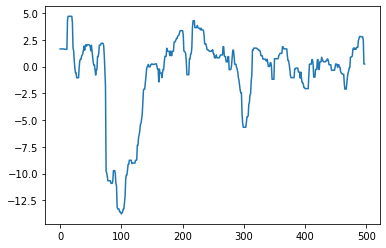

48.5


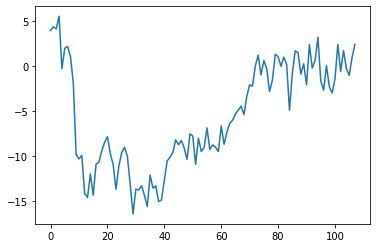

../data\Speaker1\digits\0_Speaker1_1.wav


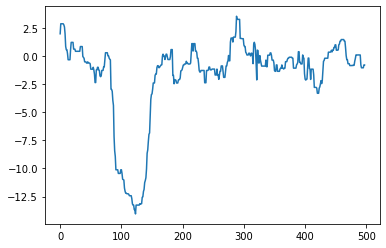

48.5


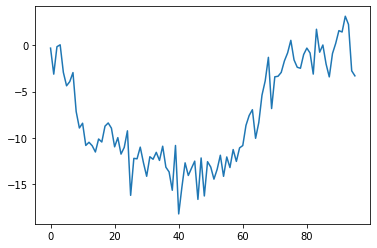

../data\Speaker1\digits\0_Speaker1_2.wav


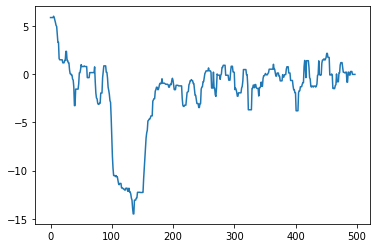

48.5


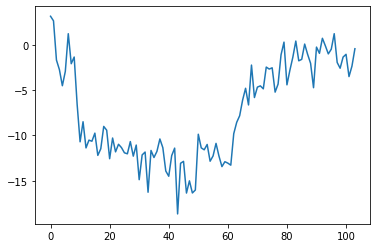

../data\Speaker1\digits\0_Speaker1_3.wav


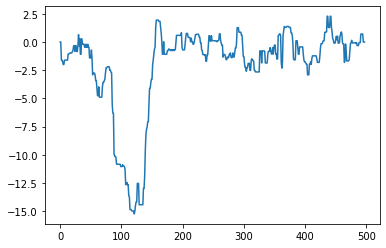

48.5


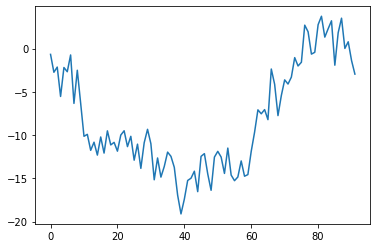

../data\Speaker1\digits\0_Speaker1_4.wav


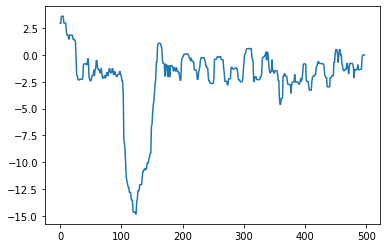

48.5


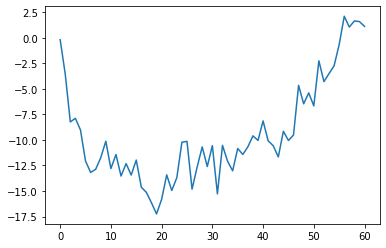

../data\Speaker1\digits\1_Speaker1_0.wav


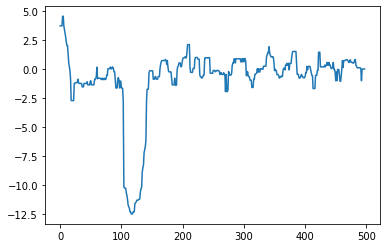

48.5


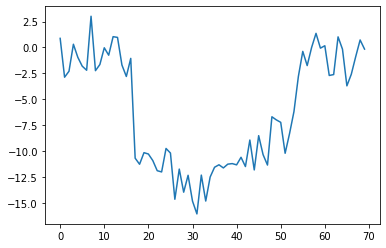

../data\Speaker1\digits\1_Speaker1_1.wav


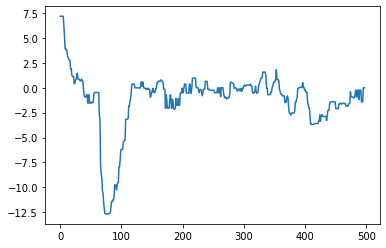

48.5


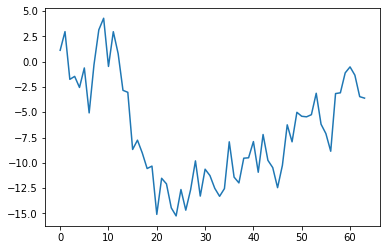

../data\Speaker1\digits\1_Speaker1_2.wav


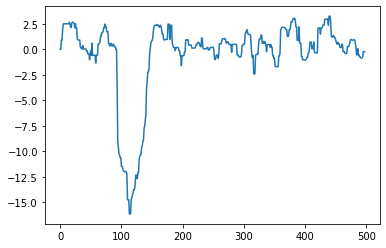

48.5


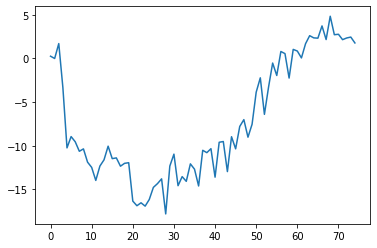

../data\Speaker1\digits\1_Speaker1_3.wav


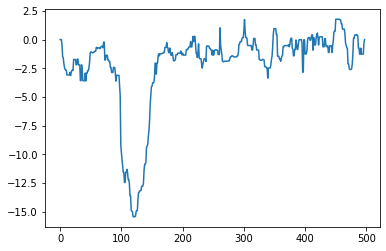

48.5


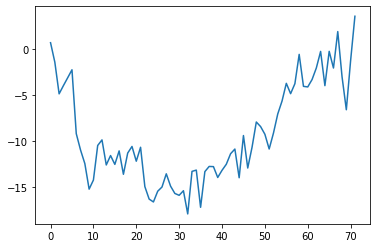

../data\Speaker1\digits\1_Speaker1_4.wav


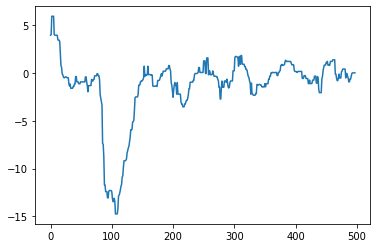

48.5


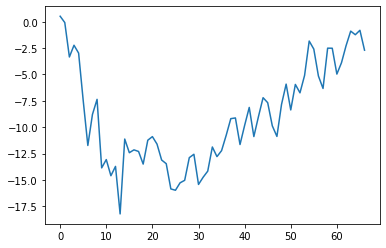

../data\Speaker1\digits\2_Speaker1_0.wav


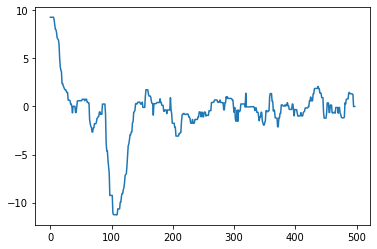

48.5


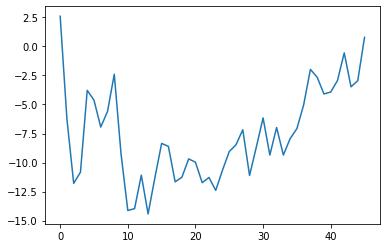

../data\Speaker1\digits\2_Speaker1_1.wav


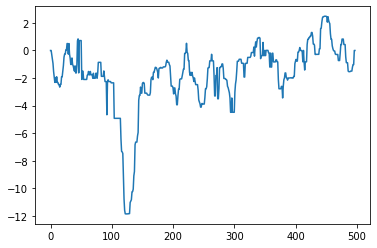

48.5


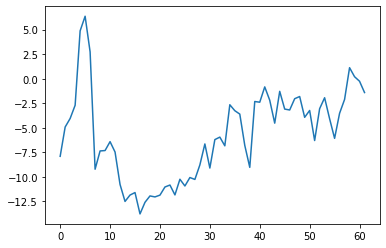

../data\Speaker1\digits\2_Speaker1_2.wav


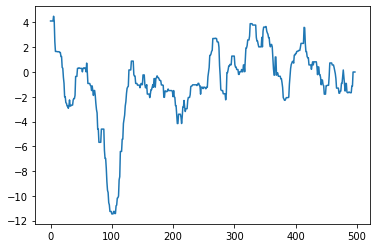

48.5


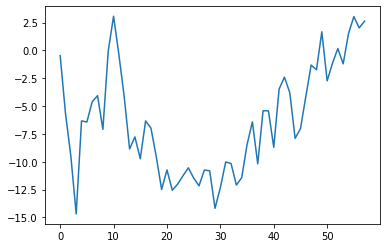

../data\Speaker1\digits\2_Speaker1_3.wav


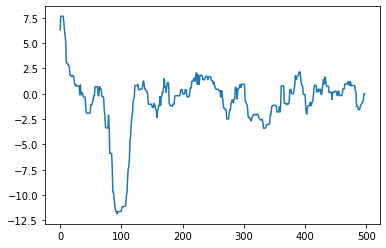

48.5


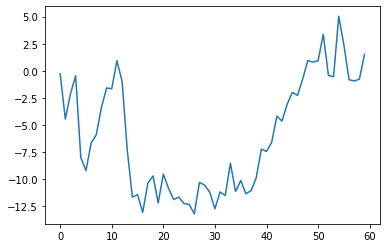

../data\Speaker1\digits\2_Speaker1_4.wav


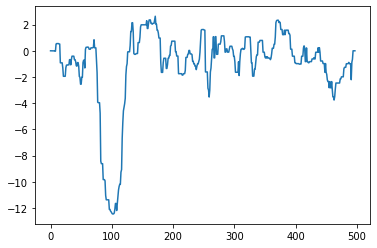

48.5


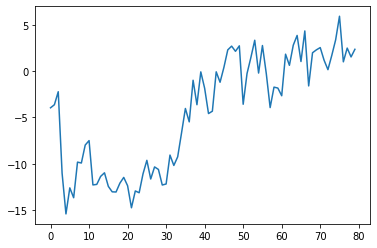

../data\Speaker1\digits\3_Speaker1_0.wav


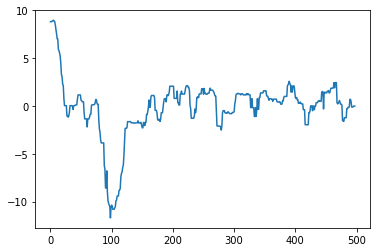

48.5


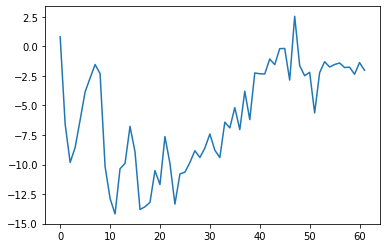

../data\Speaker1\digits\3_Speaker1_1.wav


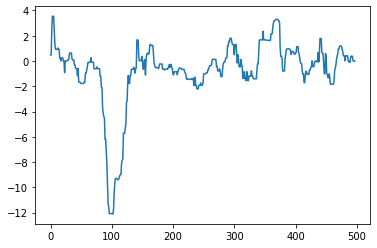

48.5


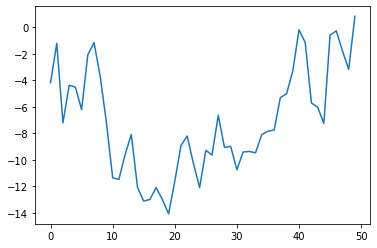

../data\Speaker1\digits\3_Speaker1_2.wav


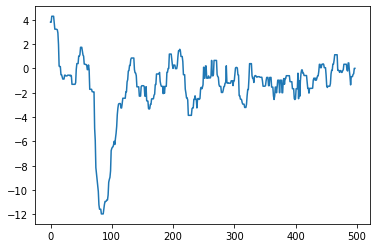

48.5


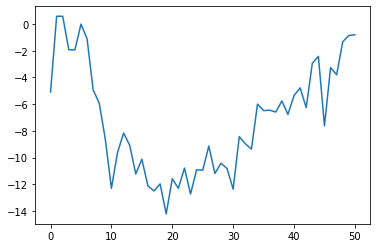

../data\Speaker1\digits\3_Speaker1_3.wav


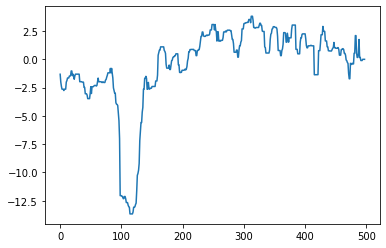

48.5


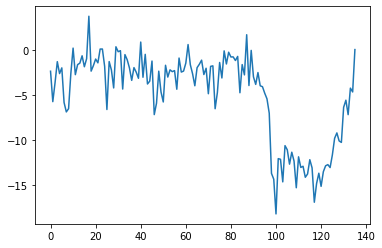

../data\Speaker1\digits\3_Speaker1_4.wav


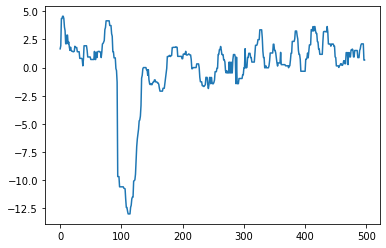

48.5


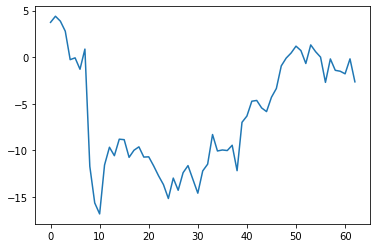

../data\Speaker1\digits\4_Speaker1_0.wav


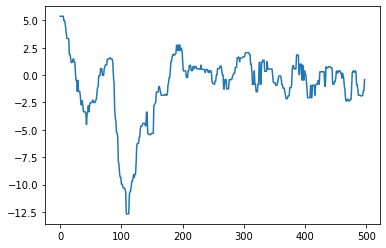

48.5


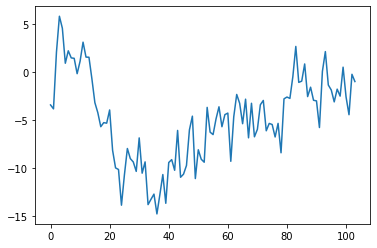

../data\Speaker1\digits\4_Speaker1_1.wav


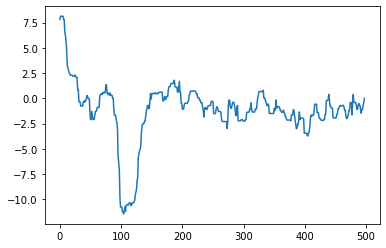

48.5


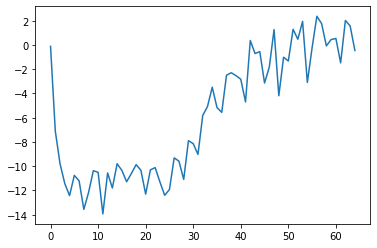

../data\Speaker1\digits\4_Speaker1_2.wav


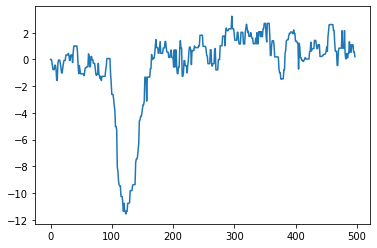

48.5


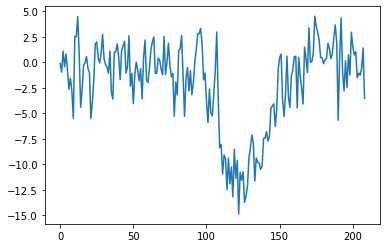

../data\Speaker1\digits\4_Speaker1_3.wav


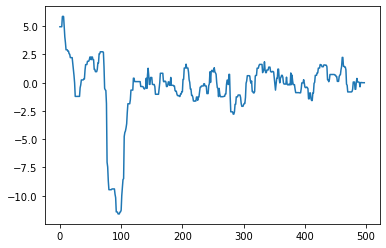

48.5


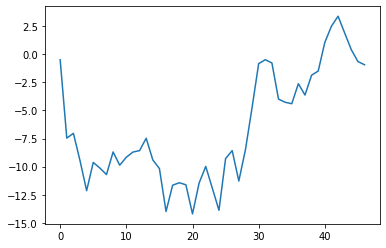

../data\Speaker1\digits\4_Speaker1_4.wav


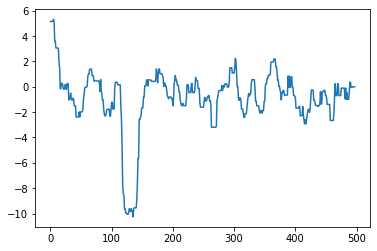

48.5


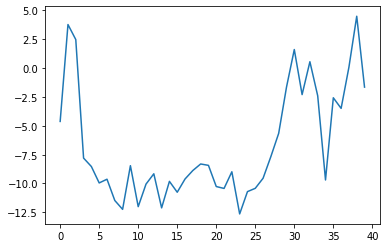

../data\Speaker1\digits\5_Speaker1_0.wav


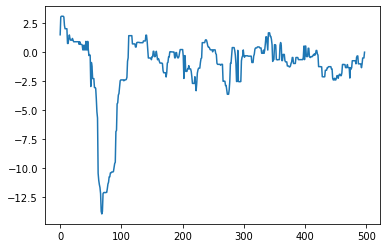

48.5


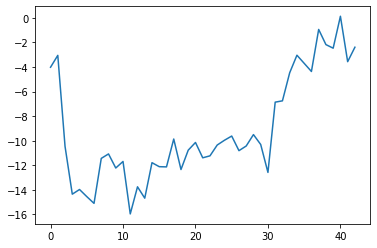

../data\Speaker1\digits\5_Speaker1_1.wav


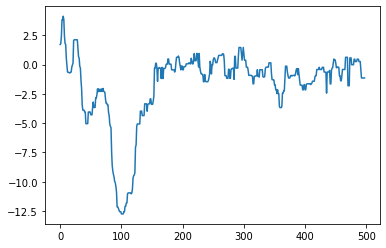

48.5


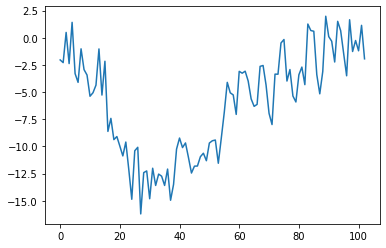

../data\Speaker1\digits\5_Speaker1_2.wav


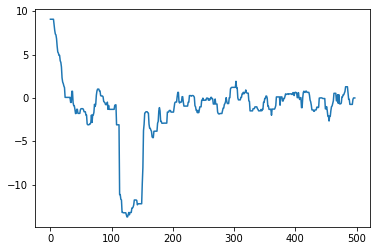

48.5


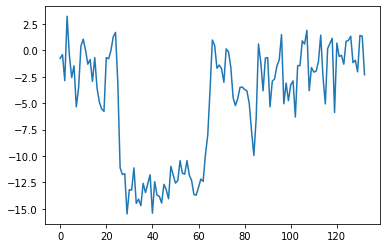

../data\Speaker1\digits\5_Speaker1_3.wav


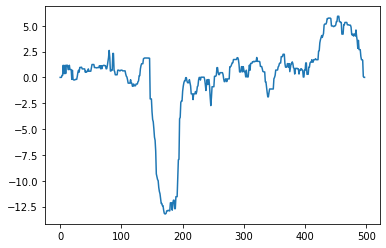

48.5


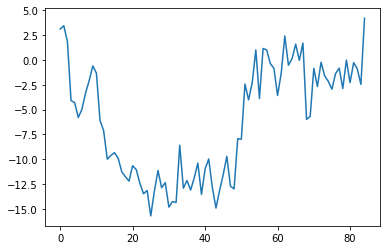

../data\Speaker1\digits\5_Speaker1_4.wav


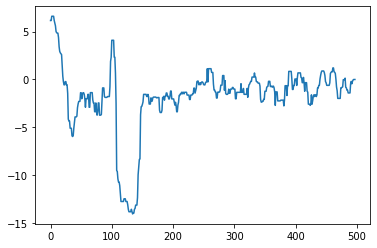

48.5


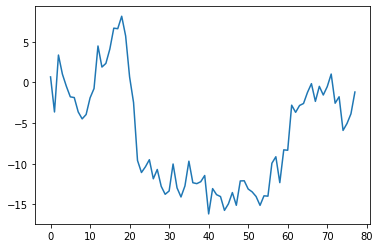

../data\Speaker1\digits\6_Speaker1_0.wav


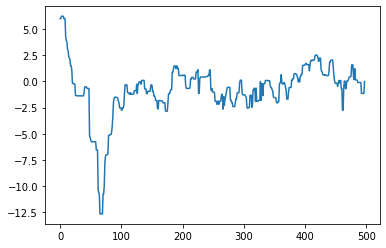

48.5


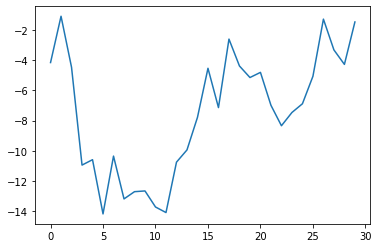

../data\Speaker1\digits\6_Speaker1_1.wav


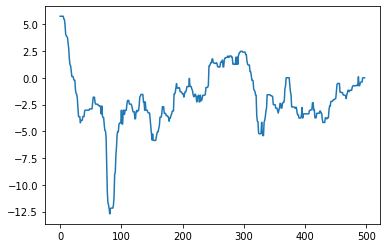

48.5


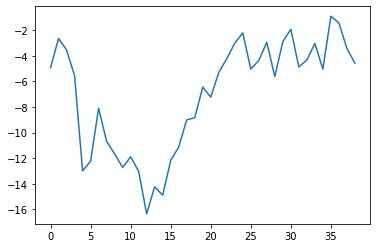

../data\Speaker1\digits\6_Speaker1_2.wav


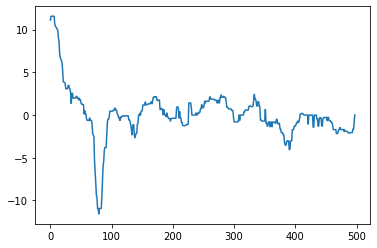

48.5


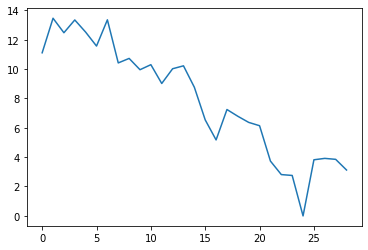

../data\Speaker1\digits\6_Speaker1_3.wav


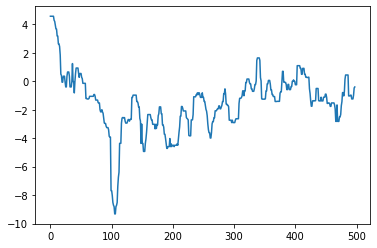

48.5


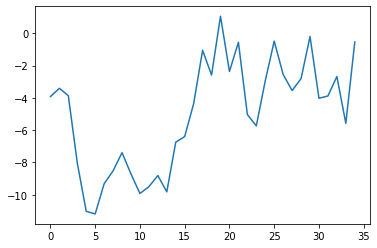

../data\Speaker1\digits\6_Speaker1_4.wav


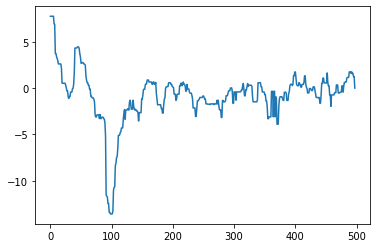

48.5


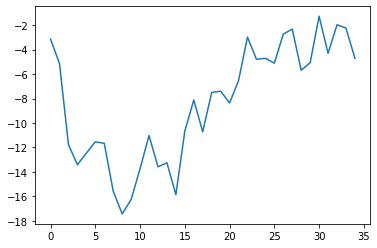

../data\Speaker1\digits\7_Speaker1_0.wav


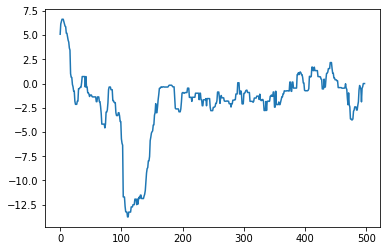

48.5


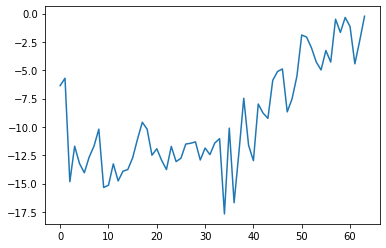

../data\Speaker1\digits\7_Speaker1_1.wav


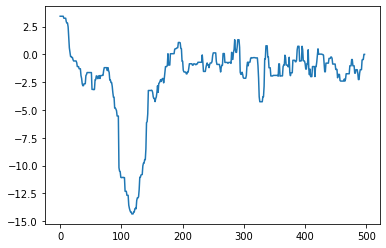

48.5


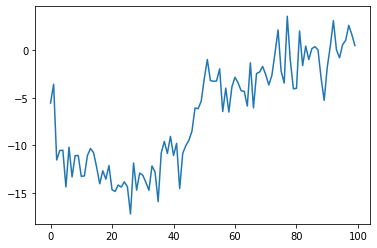

../data\Speaker1\digits\7_Speaker1_2.wav


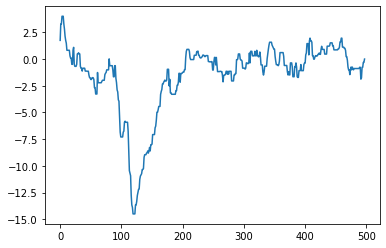

48.5


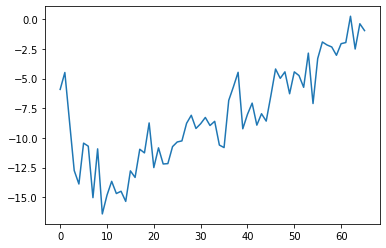

../data\Speaker1\digits\7_Speaker1_3.wav


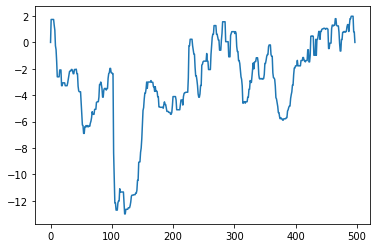

48.5


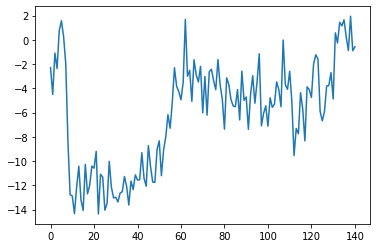

../data\Speaker1\digits\7_Speaker1_4.wav


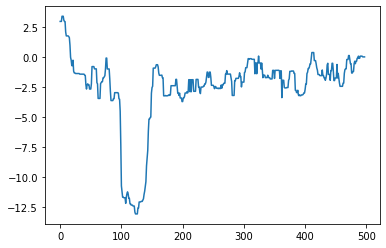

48.5


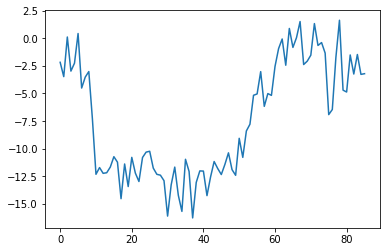

../data\Speaker1\digits\8_Speaker1_0.wav


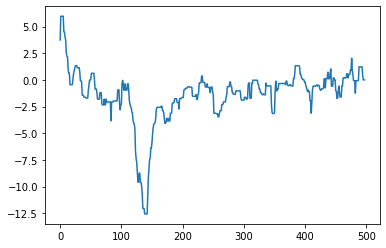

48.5


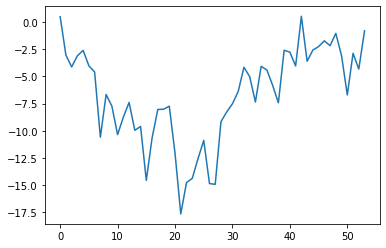

../data\Speaker1\digits\8_Speaker1_1.wav


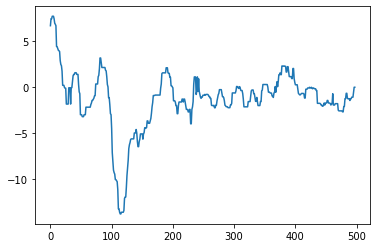

48.5


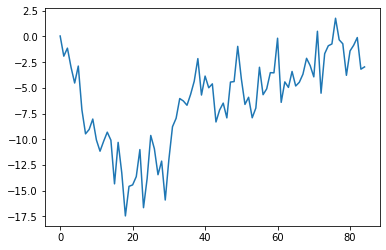

../data\Speaker1\digits\8_Speaker1_2.wav


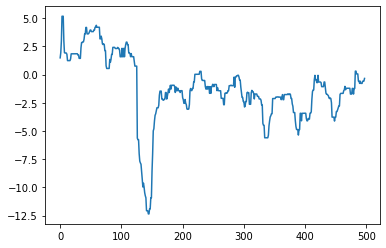

48.5


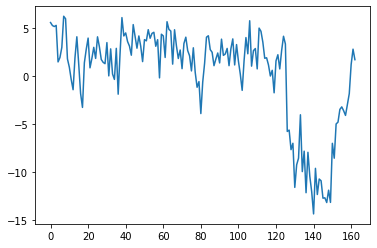

../data\Speaker1\digits\8_Speaker1_3.wav


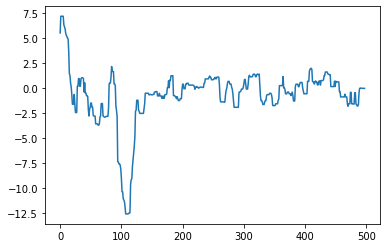

48.5


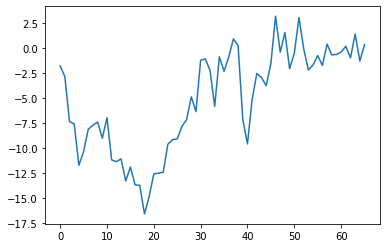

../data\Speaker1\digits\8_Speaker1_4.wav


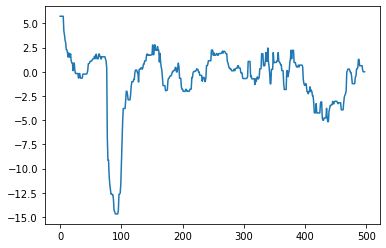

48.5


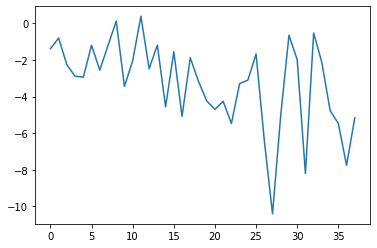

../data\Speaker1\digits\9_Speaker1_0.wav


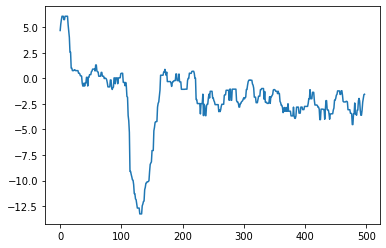

48.5


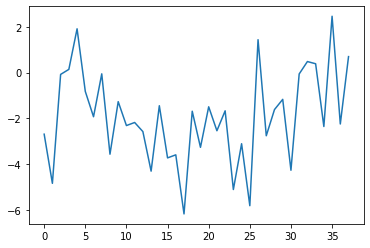

../data\Speaker1\digits\9_Speaker1_1.wav


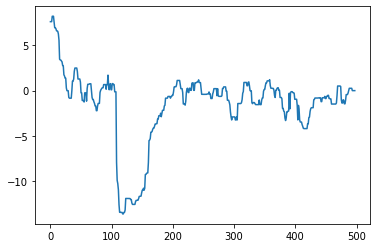

48.5


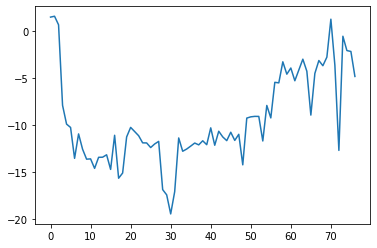

../data\Speaker1\digits\9_Speaker1_2.wav


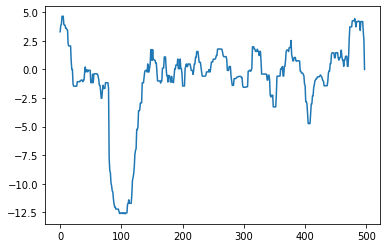

48.5


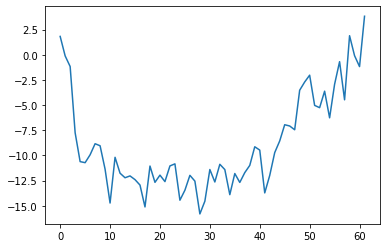

../data\Speaker1\digits\9_Speaker1_3.wav


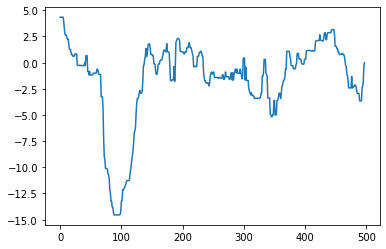

48.5


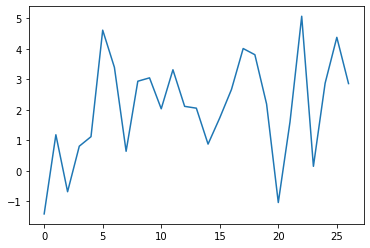

../data\Speaker1\digits\9_Speaker1_4.wav


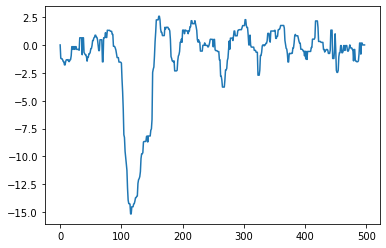

48.5


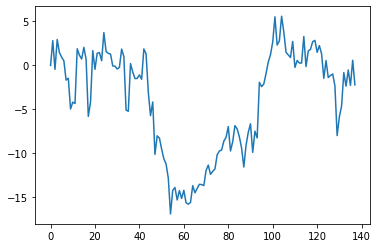

In [36]:
speakers = ['Speaker1']
for s in speakers:
    length = len(collected_files[s]) #number of digits(words)

    for d in range(length):
        
        utterances = len(collected_files[s][d])
        
        for i in range(utterances):
            sampling_rate, audio_signal = wavfile.read(collected_files[s][d][i])
            print(collected_files[s][d][i])
#             plt.plot(audio_signal)
#             plt.show()
            
            trim(sampling_rate, audio_signal)

../data\Speaker1\phrases\326807_Speaker1_s.wav


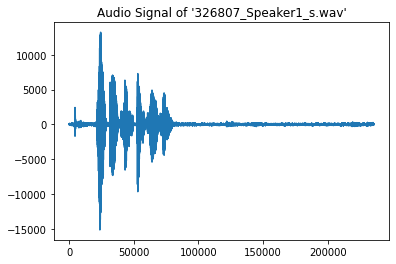

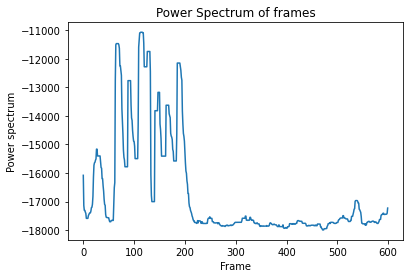

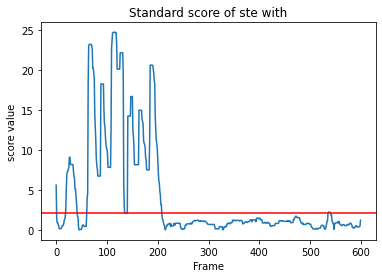

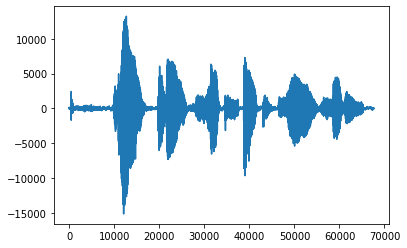

../data\Speaker1\phrases\354688_Speaker1_s.wav


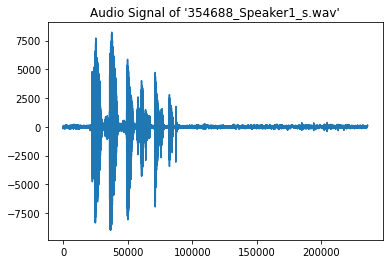

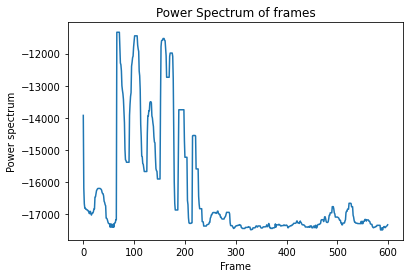

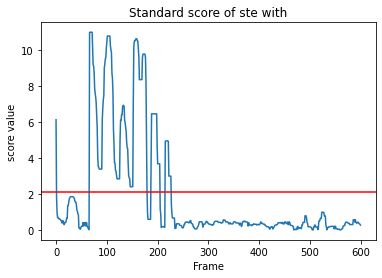

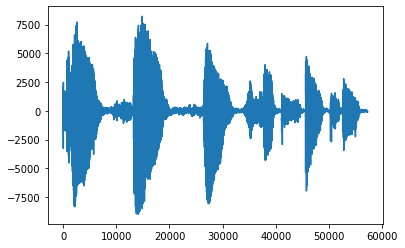

../data\Speaker1\phrases\412235_Speaker1_s.wav


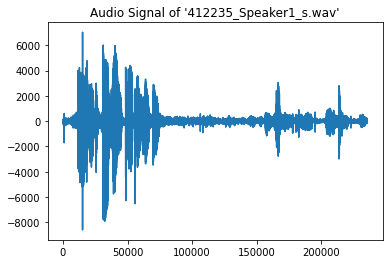

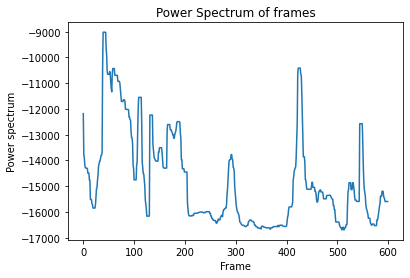

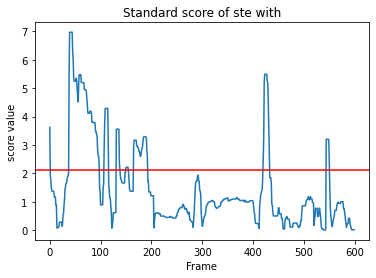

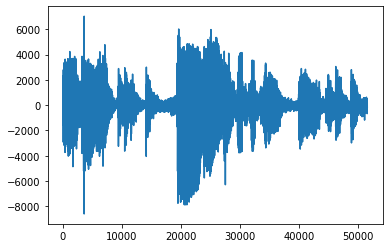

../data\Speaker1\phrases\812500_Speaker1_s.wav


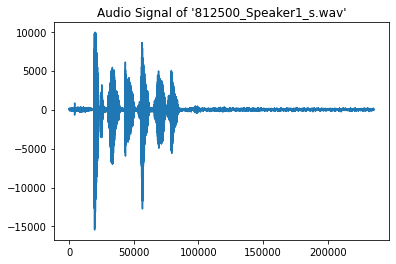

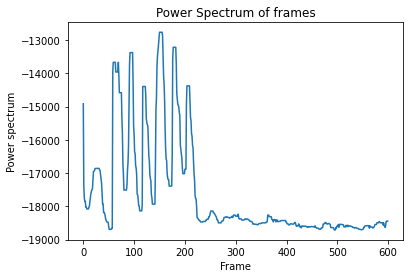

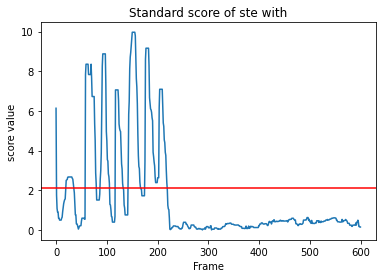

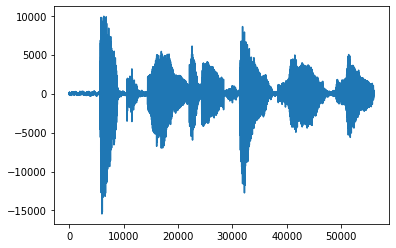

../data\Speaker6\phrases\390105_Speaker6_s.wav


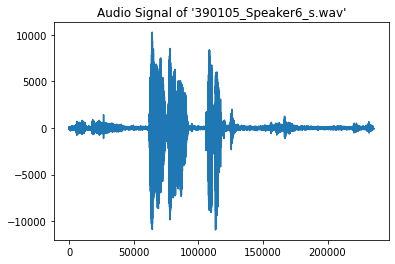

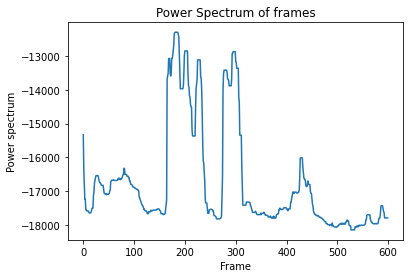

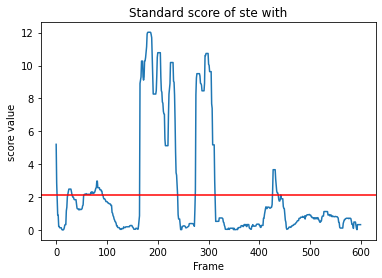

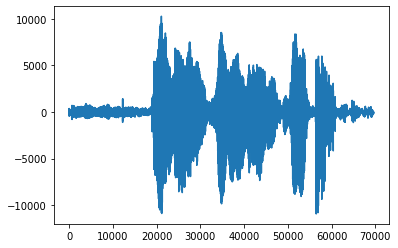

../data\Speaker6\phrases\515294_Speaker6_s.wav


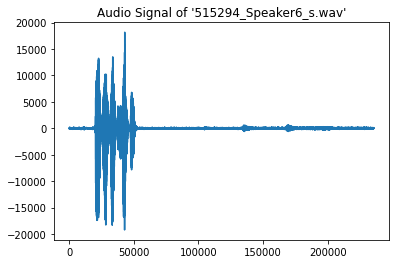

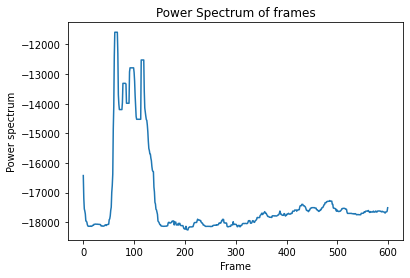

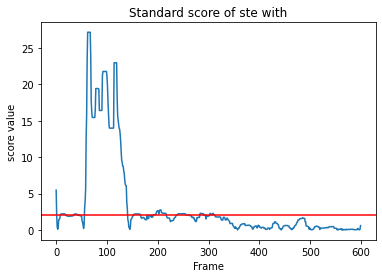

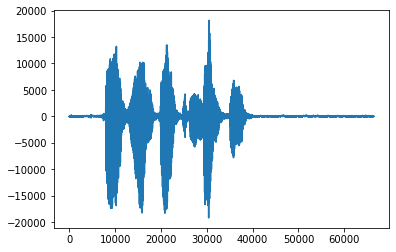

../data\Speaker6\phrases\619203_Speaker6_s.wav


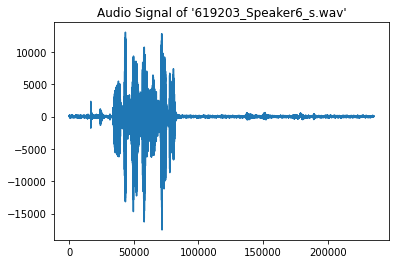

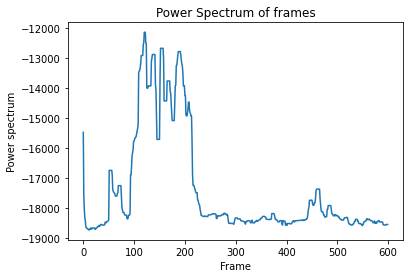

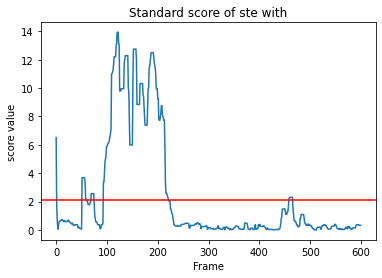

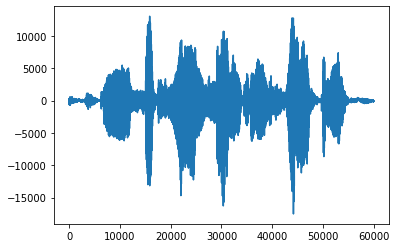

../data\Speaker6\phrases\901741_Speaker6_s.wav


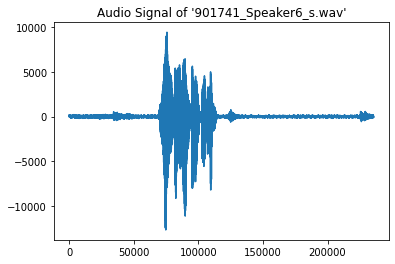

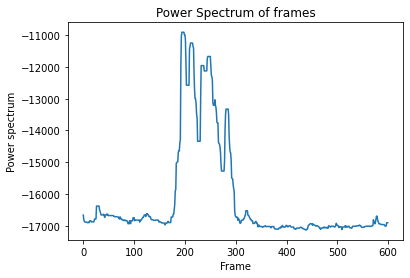

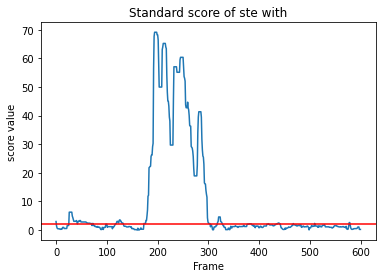

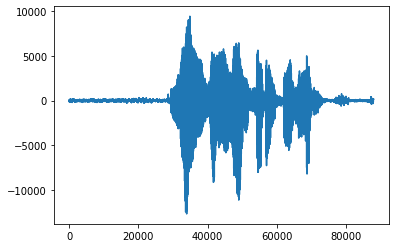

../data\Speaker6\phrases\934241_Speaker6_s.wav


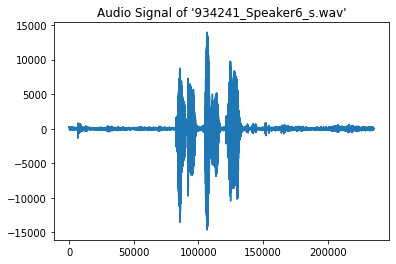

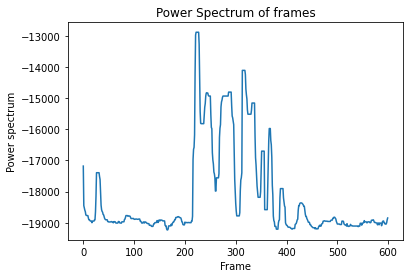

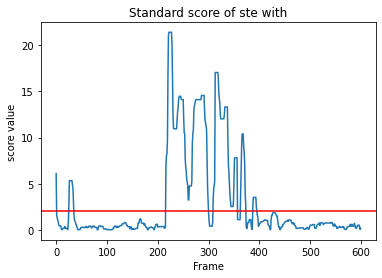

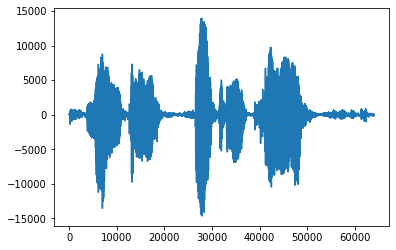

../data\Speaker7\phrases\213604_Speaker7_s.wav


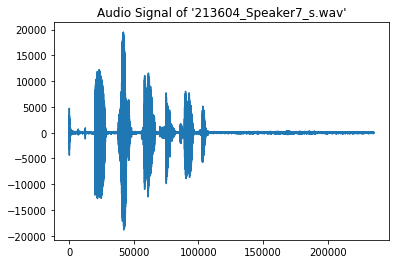

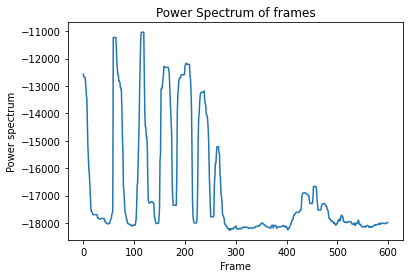

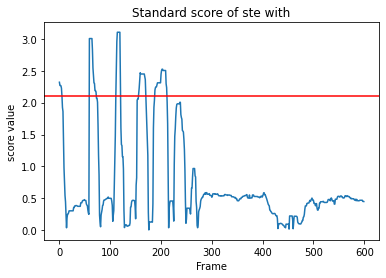

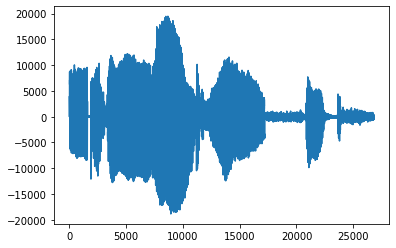

../data\Speaker7\phrases\311244_Speaker7_s.wav


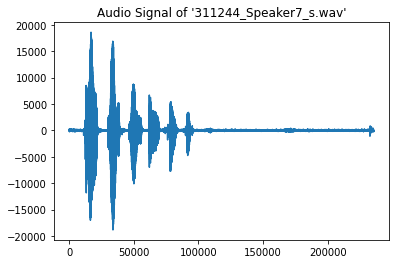

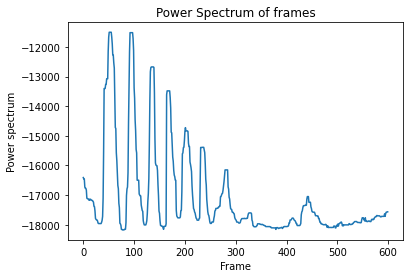

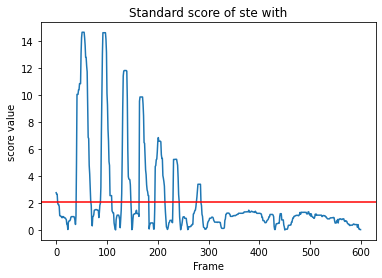

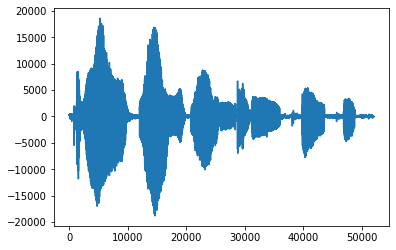

../data\Speaker7\phrases\580986_Speaker7_s.wav


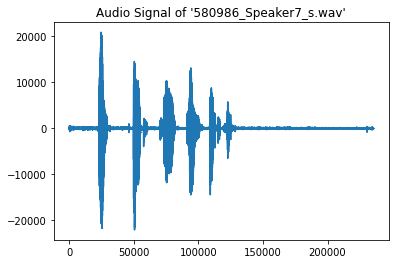

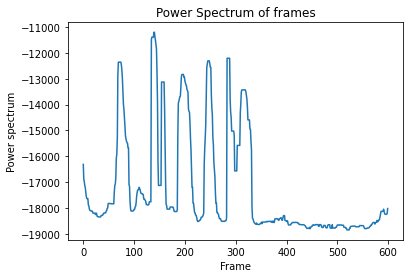

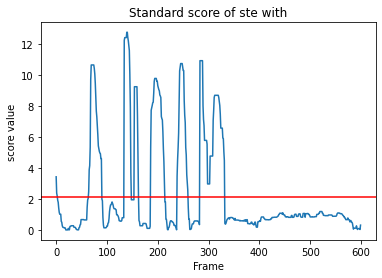

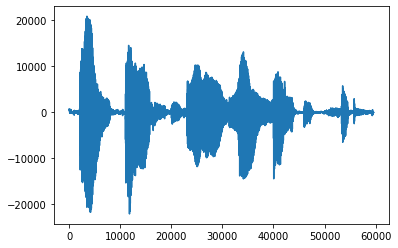

../data\Speaker7\phrases\738476_Speaker7_s.wav


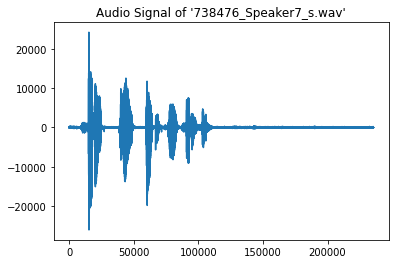

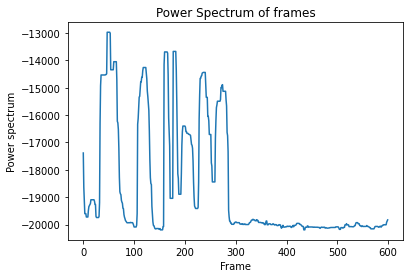

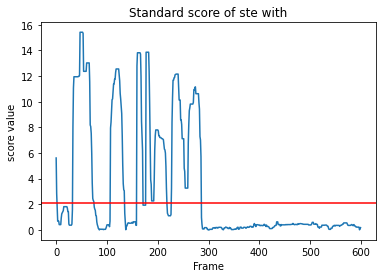

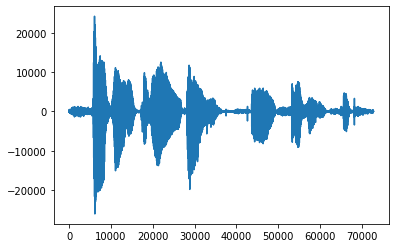

../data\Speaker7\phrases\958195_Speaker7_s.wav


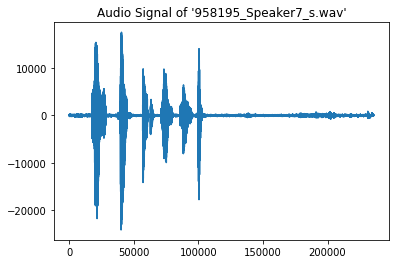

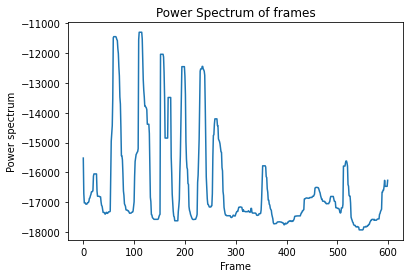

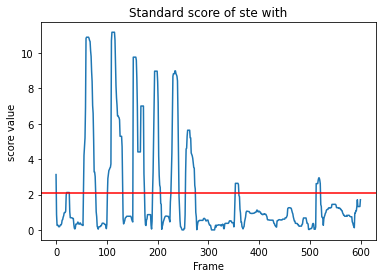

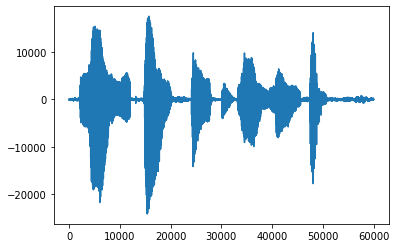

../data\Speaker8\phrases\238434_Speaker8_s.wav


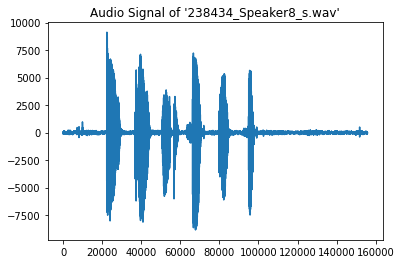

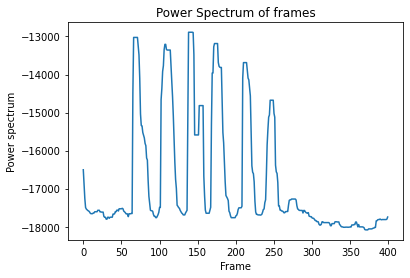

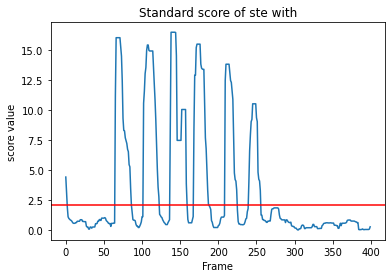

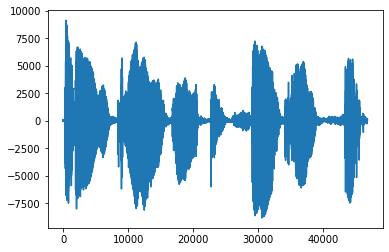

../data\Speaker8\phrases\314498_Speaker8_s.wav


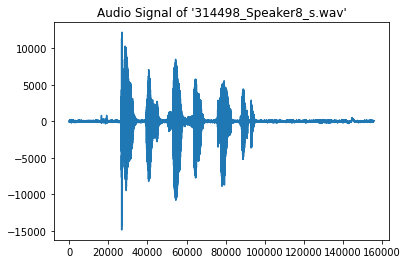

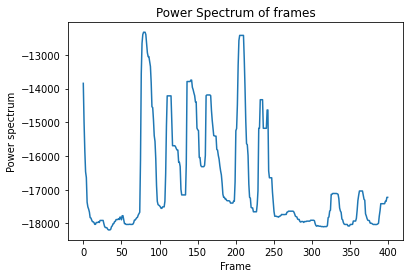

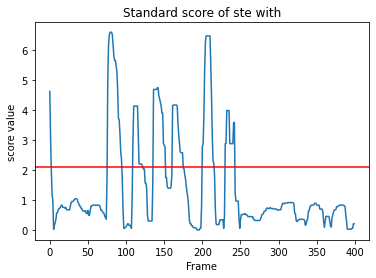

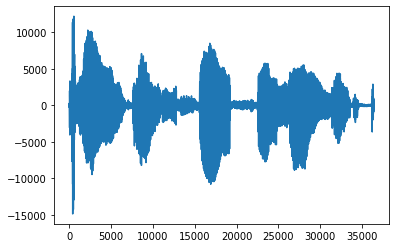

../data\Speaker8\phrases\321995_Speaker8_s.wav


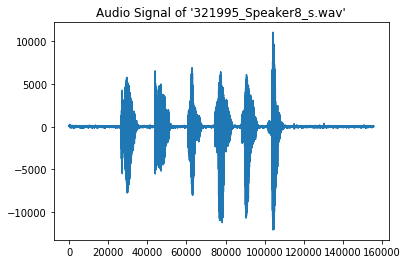

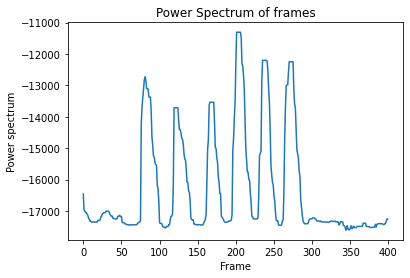

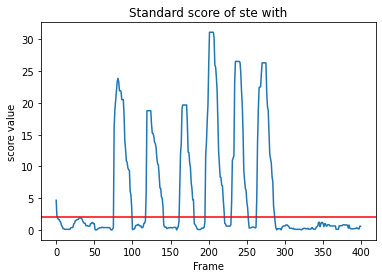

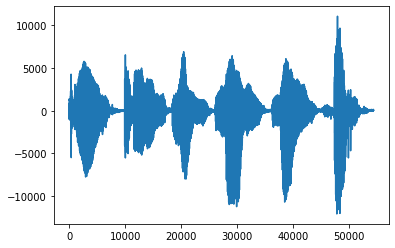

../data\Speaker8\phrases\451741_Speaker8_s.wav


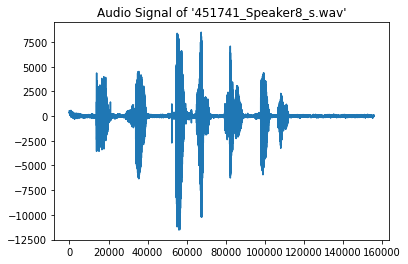

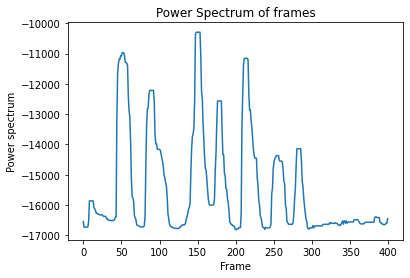

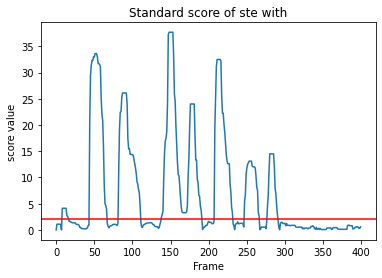

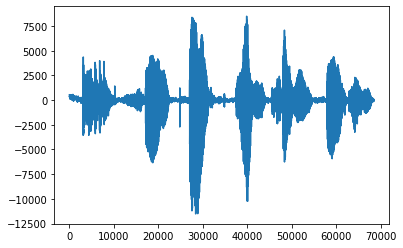

../data\Speaker8\phrases\667437_Speaker8_s.wav


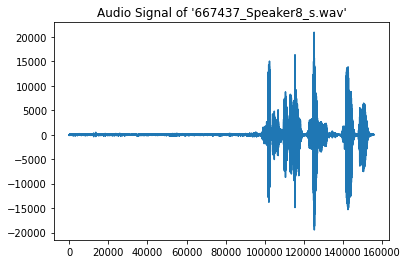

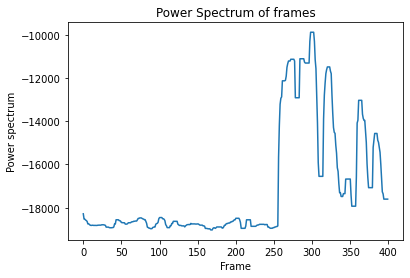

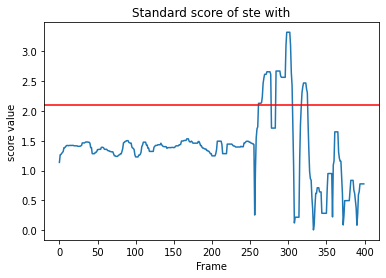

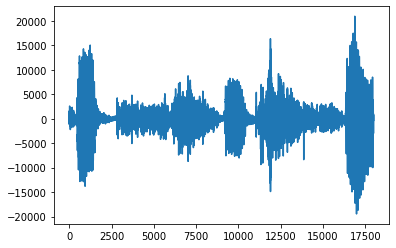

In [18]:
speakers = ['Speaker1','Speaker6','Speaker7','Speaker8']
for s in speakers:
    for f in collected_test_files[s]:
        filename = f.split("\\")
        print(f)
        sampling_rate, audio_signal = wavfile.read(f)
        
        plt.plot(audio_signal[4000:])
        plt.title("Audio Signal of %r" %filename[-1])
        plt.show()
#         ste = trim(sampling_rate, audio_signal[sampling_rate//4:-sampling_rate])
        clean = STE_v2(audio_signal, sampling_rate, startframes=10, endframes=40, dev=2.1, single_phrase=False, mutliple_phrases=True)
        plt.plot(clean)
        plt.show()
        
        


In [7]:
alternative_files = ['../data\\Speaker1\\phrases\\326807_Speaker1_s.wav','../data\\Speaker1\\phrases\\354688_Speaker1_s.wav','../data\\Speaker1\\phrases\\412235_Speaker1_s.wav','../data\\Speaker1\\phrases\\812500_Speaker1_s.wav','../data\\Speaker2\\phrases\\173488_Speaker2_s.wav','../data\\Speaker2\\phrases\\387038_Speaker2_s.wav','../data\\Speaker2\\phrases\\593777_Speaker2_s.wav','../data\\Speaker2\\phrases\\763236_Speaker2_s.wav','../data\\Speaker2\\phrases\\795010_Speaker2_s.wav','../data\\Speaker6\\phrases\\390105_Speaker6_s.wav','../data\\Speaker6\\phrases\\515294_Speaker6_s.wav','../data\\Speaker6\\phrases\\619203_Speaker6_s.wav','../data\\Speaker6\\phrases\\901741_Speaker6_s.wav','../data\\Speaker6\\phrases\\934241_Speaker6_s.wav','../data\\Speaker7\\phrases\\213604_Speaker7_s.wav','../data\\Speaker7\\phrases\\311244_Speaker7_s.wav','../data\\Speaker7\\phrases\\580986_Speaker7_s.wav','../data\\Speaker7\\phrases\\738476_Speaker7_s.wav','../data\\Speaker7\\phrases\\958195_Speaker7_s.wav','../data\\Speaker8\\phrases\\238434_Speaker8_s.wav','../data\\Speaker8\\phrases\\314498_Speaker8_s.wav','../data\\Speaker8\\phrases\\321995_Speaker8_s.wav','../data\\Speaker8\\phrases\\451741_Speaker8_s.wav','../data\\Speaker8\\phrases\\667437_Speaker8_s.wav','../data\\Speaker9\\phrases\\149061_Speaker9_s.wav','../data\\Speaker9\\phrases\\239088_Speaker9_s.wav','../data\\Speaker9\\phrases\\578232_Speaker9_s.wav','../data\\Speaker9\\phrases\\735776_Speaker9_s.wav','../data\\Speaker9\\phrases\\821102_Speaker9_s.wav']

for f in alternative_files:
    
    sampling_rate, audio_signal = wavfile.read(f)
    print(f)
    plt.plot(audio_signal[4000:-sampling_rate])
    plt.title("Audio Signal of %r" %f)
    plt.show()
#     trim(sampling_rate, audio_signal[sampling_rate//4:-sampling_rate])
    clean = STE_v2(audio_signal, sampling_rate, startframes=10, endframes=40, dev=2.5, single_phrase=False, mutliple_phrases=True)
    plt.plot(clean)
    plt.show()
        
    

FileNotFoundError: [Errno 2] No such file or directory: '../data\\Speaker1\\phrases\\326807_Speaker1_s.wav'

In [127]:
speakers_to_test ={'Speaker3': ['../data\\Speaker3\\phrases\\317623_Speaker3_s.wav',
  '../data\\Speaker3\\phrases\\346014_Speaker3_s.wav',
  '../data\\Speaker3\\phrases\\535583_Speaker3_s.wav',
  '../data\\Speaker3\\phrases\\639398_Speaker3_s.wav',
  '../data\\Speaker3\\phrases\\681130_Speaker3_s.wav'],
 'Speaker4': ['../data\\Speaker4\\phrases\\050667_Speaker4_s.wav',
  '../data\\Speaker4\\phrases\\126014_Speaker4_s.wav',
  '../data\\Speaker4\\phrases\\199973_Speaker4_s.wav',
  '../data\\Speaker4\\phrases\\475596_Speaker4_s.wav',
  '../data\\Speaker4\\phrases\\716092_Speaker4_s.wav'],
 'Speaker5': ['../data\\Speaker5\\phrases\\205563_Speaker5_s.wav',
  '../data\\Speaker5\\phrases\\315115_Speaker5_s.wav',
  '../data\\Speaker5\\phrases\\470964_Speaker5_s.wav',
  '../data\\Speaker5\\phrases\\685967_Speaker5_s.wav',
  '../data\\Speaker5\\phrases\\914518_Speaker5_s.wav']}

In [130]:
len(alternative_files)

29

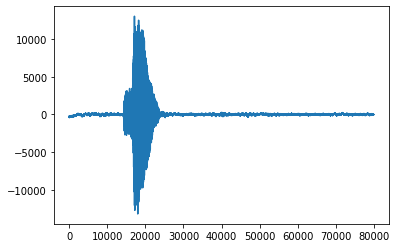

In [6]:

sampling_rate, audio_signal = wavfile.read('../data\\Speaker1\\digits\\0_Speaker1_1.wav')
plt.plot(audio_signal)
plt.show()
